In [17]:
import numpy as np
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt

# Gaussian Mixture Model (GMM)

In [18]:
class gmm:
    def __init__(self, K):
        self.K = K
        self.pi = None
        self.mu = None
        self.sigma = None

    def fit(self, x, max_iter=100, eps=0.001, smoothing=1e-2):
        N, D = x.shape

        self.mu = np.zeros((self.K, D))
        self.sigma = np.zeros((self.K ,D, D))
        self.pi = np.ones(self.K) / self.K  # uniform initial distribution

        R = np.zeros((N, self.K))  # cluster responsibilities

        ll_history = []
        for k in range(self.K):
            self.mu[k] = x[np.random.choice(N)]
            self.sigma[k] = np.eye(D)

        for step in range(max_iter):
            # E step
            weighted_pdfs = np.zeros((N, self.K))
            for k in range(self.K):
                weighted_pdfs[:, k] = self.pi[k] * multivariate_normal.pdf(x, self.mu[k, :], self.sigma[k, :, :])
            R = weighted_pdfs / weighted_pdfs.sum(axis=1, keepdims=True)

            # M step
            for k in range(self.K):
                Nk = R[:, k].sum()
                self.pi[k] = Nk / N
                self.mu[k, :] = R[:, k].dot(x) / Nk

                x_mu = x - self.mu[k, :]
                self.sigma[k, :, :] = (np.expand_dims(R[:, k], -1) * x_mu).T.dot(x_mu) / (Nk + np.eye(D) * smoothing)

            log_ll = np.log(weighted_pdfs.sum(axis=1)).sum()
            ll_history.append(log_ll)

            if step > 1:
                if np.abs(ll_history[-1] - ll_history[-2]) < eps:
                    print(f'early stop after {step} steps')
                    break

        return R, ll_history

    def predict(self, x):
        weighted_pdfs = np.zeros((len(x), self.K))
        for k in range(self.K):
            weighted_pdfs[:, k] = self.pi[k] * multivariate_normal.pdf(x, self.mu[k, :], self.sigma[k, :, :])
        R = weighted_pdfs / weighted_pdfs.sum(axis=1, keepdims=True)
        return R, R.argmax(axis=1)

# Use gmm on cloud data

In [19]:
def plot_clusters(x, y, centres=None):
    plt.figure(figsize=(10, 10))
    plt.scatter(x[:, 0], x[:, 1], c=y, alpha=0.7, s=20)

    if centres is not None:
        n_centres = len(centres)
        for i, c in enumerate(centres):
            plt.scatter(c[:, 0], c[:, 1], c=np.arange(c.shape[0]), marker='*', s=1000, alpha=(i + 1) / n_centres)
    plt.show()

def get_cloud_data(K, D):
    shift = 4

    n0 = 1200
    n1 = 1800
    n2 = 200
    N = n0 + n1 + n2

    mu0 = np.array([0, 0])
    mu1 = np.array([shift, shift])
    mu2 = np.array([0, shift])

    sigma0 = 2
    sigma1 = 1
    sigma2 = 0.5

    X = np.random.randn(N, D)
    X[:n0, :] = X[:n0, :] * sigma0 + mu0
    X[n0:(n0+n1), :] = X[n0:(n0+n1), :] * sigma1 + mu1
    X[(n0+n1):, :] = X[(n0+n1):, :] * sigma2 + mu2

    y = np.array([0] * n0 + [1] * n1 + [2] * n2)

    ids = np.arange(N)
    np.random.shuffle(ids)
    X = X[ids]
    y = y[ids]

    plot_clusters(X, y)

    # plot centres
    shuffle_ids = np.arange(N)
    np.random.shuffle(shuffle_ids)
    centres = X[shuffle_ids[:K]]

    return X, y, centres

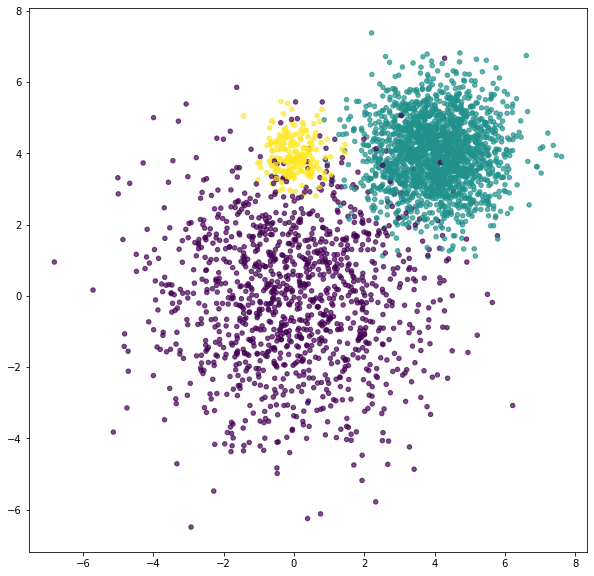

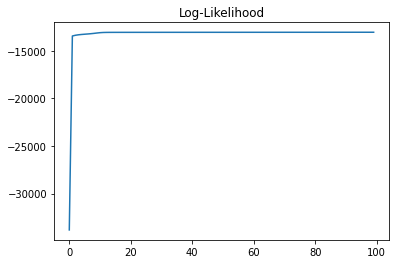

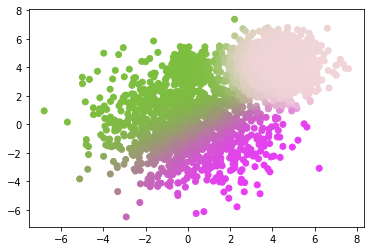

pi: [0.13135952 0.32045493 0.54818555]
means: [[ 1.04959428 -1.38834274]
 [-0.30981477  1.51687745]
 [ 4.070568    4.01080371]]
covariances: [[[3.24332132 0.80503261]
  [0.80503261 2.74251357]]

 [[2.94900601 1.19688699]
  [1.19688699 4.55283062]]

 [[0.96208201 0.01819781]
  [0.01819781 0.96253061]]]
predicted classes: [1 2 1 2]


In [20]:
K = 3
BASE_COLOR = np.random.random((K, 3))
X, _, _ = get_cloud_data(K, D=2)

model = gmm(K)
R, ll_history = model.fit(X)

mixture_weight, mu, sigma = model.pi, model.mu, model.sigma

plt.plot(ll_history)
plt.title("Log-Likelihood")
plt.show()

random_colors = np.random.random((K, 3))
colors = R.dot(random_colors)
plt.scatter(X[:,0], X[:,1], c=colors)
plt.show()

print("pi:", mixture_weight)
print("means:", mu)
print("covariances:", sigma)

X_test = np.array([
                   [0, 0],
                   [4, 4],
                   [0, 4],
                   [5, 5]])
r_pred, y_pred = model.predict(X_test)
print('predicted classes:', y_pred)

# Use gmm (sklearn implementation) on MNIST data

In [21]:
import pandas as pd
from sklearn.mixture import GaussianMixture

In [22]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

#def get_mnist():
mnist_df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/lazyprogrammer/data/mnist.csv', header='infer')

if mnist_df.isna().sum().max() == 0:
  print('There is no NA values')
else:
  print(f'There are {mnist_df.isna().sum().max()} NAs' )

mnist_df.head()

Mounted at /content/gdrive/
There is no NA values


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
def plot_examples(x, y, cmap='gray', labels=None):
  plt.figure(figsize=(15,15))
  for i in range(25):
      plt.subplot(5,5,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(x[i], cmap=cmap)
      if labels==None:
        plt.xlabel(y[i])
      else:
        plt.xlabel(labels[y[i]])
  plt.show()


def shuffle_pairs(X, Y):
  N = len(X)
  indexes = np.arange(N)
  np.random.shuffle(indexes)
  X = X[indexes]
  Y = Y[indexes]
  return X, Y


def get_mnist_data(should_shuffle = True, should_plot_examples=True):
  mnist_data = mnist_df.copy().values
  if (should_shuffle == True):
    np.random.shuffle(mnist_data)
  Y_mnist = mnist_data[:, 0]
  X_mnist = np.divide(mnist_data[:, 1:], 255.0)
  picture_shape = (28, 28)

  if (should_plot_examples == True):
    plot_examples(X_mnist.reshape((-1, *picture_shape)), Y_mnist, cmap='gray', labels=None)
  return X_mnist, Y_mnist, picture_shape

In [24]:
norm_vec = np.vectorize(lambda x: x.dot(x), signature='(d)->()')

def purity_soft_cost(y, weights):
    n_clusters = weights.shape[1]
    clusters_purity = []
    for c1 in range(n_clusters):
        one_class_putiry = []
        for c2 in range(n_clusters):
            one_class_putiry.append(np.sum(weights[y == c2, c1]))
        clusters_purity.append(np.max(one_class_putiry))
    return np.sum(clusters_purity) / len(y)

def davis_bouldin_index_soft_cost(x, weights, cluster_centres, dist_calc_func=norm_vec):
    K = len(cluster_centres)
    sigma = np.zeros(K)
    for k in range(K):
        d = weights[:, k] * dist_calc_func(x - cluster_centres[k])
        sigma[k] = np.sqrt(d.sum() / weights[:, k].sum())

    clusters_divergence = []
    for i in range(K):
        one_class_divergence = []
        for j in range(K):
            if i != j:
                dc = np.sqrt(dist_calc_func(cluster_centres[i] - cluster_centres[j]))
                one_class_divergence.append((sigma[i] + sigma[j]) / dc)
        clusters_divergence.append(np.max(one_class_divergence))
    return np.mean(clusters_divergence)

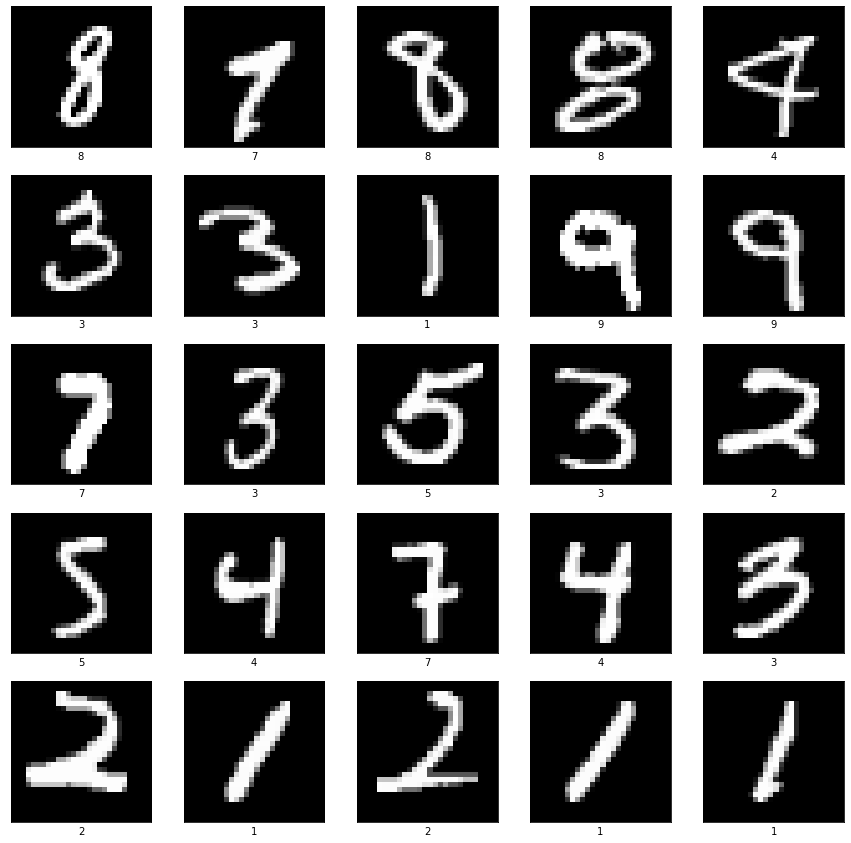

In [25]:
Nmnist = 10000

Xmnist, Ymnist, pic_shape = get_mnist_data()
Xmnist = Xmnist[:Nmnist]
Ymnist = Ymnist[:Nmnist]

In [26]:
model = GaussianMixture(n_components=10)
model.fit(Xmnist)
Mmnist = model.means_
Rmnist = model.predict_proba(Xmnist)

In [27]:
print("Purity:", purity_soft_cost(Ymnist, Rmnist)) # max is 1, higher is better
print("DBI:", davis_bouldin_index_soft_cost(Xmnist, Rmnist, Mmnist)) # lower is better

Purity: 0.5222992311922668
DBI: 3.2745854538965027
